In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cv2
from sklearn import linear_model

%matplotlib inline 
matplotlib.rcParams["figure.figsize"] = (16.0, 8.0)

class LaneTracker(object):
    def __init__(self, img, horizon_threshold, theta_threshold):
        self.img = img
        self.horizon_threshold = horizon_threshold
        self.theta_threshold = theta_threshold
        self.line_segments = None
        self.left_lane = None
        self.right_lane = None
        self.mid_lane = None
        
    def get_hough_lines(self):
        edged = cv2.Canny(gray, 50, 200, apertureSize = 3)
        minLineLength = 100
        maxLineGap = 10
        lines = cv2.HoughLinesP(edged, 1, np.pi/180, 100, minLineLength, maxLineGap)

        # De-nest the list one level (for some reason, each set of points is in a nested list)
        self.line_segments = list([l[0] for l in lines])
        
    def get_theta(self, x):
        x1, y1, x2, y2 = x
        return np.abs(np.arctan2((y2-y1), (x2-x1)))
        
    def filter_lines(self):
        if self.line_segments is None:
            self.get_hough_lines()
        
        # Filter out those lines above the horizon
        horizon = self.horizon_threshold * self.img.shape[0]
        self.line_segments = list(filter(lambda x: x[1]>horizon and x[3] > horizon, self.line_segments))
        
        # Filter out those lines that are too horizontal
        self.line_segments = list(filter(lambda x: self.get_theta(x) > self.theta_threshold, self.line_segments))  # line angle WRT horizon

    def get_LR_lanes(self):
        self.filter_lines()
        
        centre_x = self.img.shape[1] / 2

        # Get all the lines that have an average x value to the left of centre, and same for right
        lines_left = list(filter(lambda x: (x[0] + x[2]) / 2 < centre_x, self.line_segments))
        lines_right = list(filter(lambda x: (x[0] + x[2]) / 2 >= centre_x, self.line_segments))

        # Fancy list comprehension - get the elements at even positions in the sublists and flatten into one 
        lines_left_x = np.transpose(np.asarray([[item for sublist in lines_left for item in sublist[0::2]]]))
        lines_left_y = np.transpose(np.asarray([[item for sublist in lines_left for item in sublist[1::2]]]))

        lines_right_x = np.transpose(np.asarray([[item for sublist in lines_right for item in sublist[0::2]]]))
        lines_right_y = np.transpose(np.asarray([[item for sublist in lines_right for item in sublist[1::2]]]))

        # Fit line using RANSAC
        model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
        
        model_ransac.fit(lines_left_x, lines_left_y)
        self.left_lane = (model_ransac.estimator_.coef_, model_ransac.estimator_.intercept_)

        model_ransac.fit(lines_right_x, lines_right_y)
        self.right_lane = (model_ransac.estimator_.coef_, model_ransac.estimator_.intercept_)
        
    def get_mid_lane(self):
        self.get_LR_lanes()
        
        m_left, c_left = self.left_lane
        m_right, c_right = self.right_lane
        intersection_x = (c_left - c_right) / (m_right - m_left)
        intersection_y = m_left * intersection_x + c_left

        m_mid = np.tan((np.arctan(m_right) + np.arctan(m_left) - np.pi) / 2 ) 
        c_mid = intersection_y - m_mid * intersection_x
        
        self.mid_lane = (m_mid, c_mid)
        x_bottom = (self.img.shape[0] - c_mid) / m_mid
        
        # Return the offset of the center line from the middle of the frame, and the orientation of the line
        return (x_bottom - self.img.shape[1] / 2, m_mid)
    
    def plot_img(self):
        new_img = self.img
        
        if self.line_segments is not None:
            for x1, y1, x2, y2 in self.line_segments:
                cv2.line(new_img, (x1, y1),(x2, y2), (0, 0, 255), 5)
                
        if self.left_lane is not None and self.right_lane is not None:
            x_horiz_left = int((self.img.shape[0] * self.horizon_threshold - self.left_lane[1]) / self.left_lane[0])
            x_bottom_left = int((self.img.shape[0] - self.left_lane[1]) / self.left_lane[0])
            cv2.line(new_img, (x_horiz_left, int(self.img.shape[0] * self.horizon_threshold)), (x_bottom_left, self.img.shape[0]), \
                     (255, 255, 255), 5)
                     
            x_horiz_right = int((self.img.shape[0] * self.horizon_threshold - self.right_lane[1]) / self.right_lane[0])
            x_bottom_right = int((self.img.shape[0] - self.right_lane[1]) / self.right_lane[0])
            cv2.line(new_img, (x_horiz_right,int(self.img.shape[0] * self.horizon_threshold)), (x_bottom_right, self.img.shape[0]), \
                    (255, 255, 255), 5)                     
            
        if self.mid_lane is not None:
            x_horiz_mid = int((self.img.shape[0] * self.horizon_threshold - self.mid_lane[1]) / self.mid_lane[0])
            x_bottom_mid = int((self.img.shape[0] - self.mid_lane[1]) / self.mid_lane[0])
            cv2.line(new_img, (x_horiz_mid, int(self.img.shape[0] * self.horizon_threshold)), (x_bottom_mid, self.img.shape[0]), \
                    (255, 255, 255), 5) 
        
        plt.imshow(new_img)

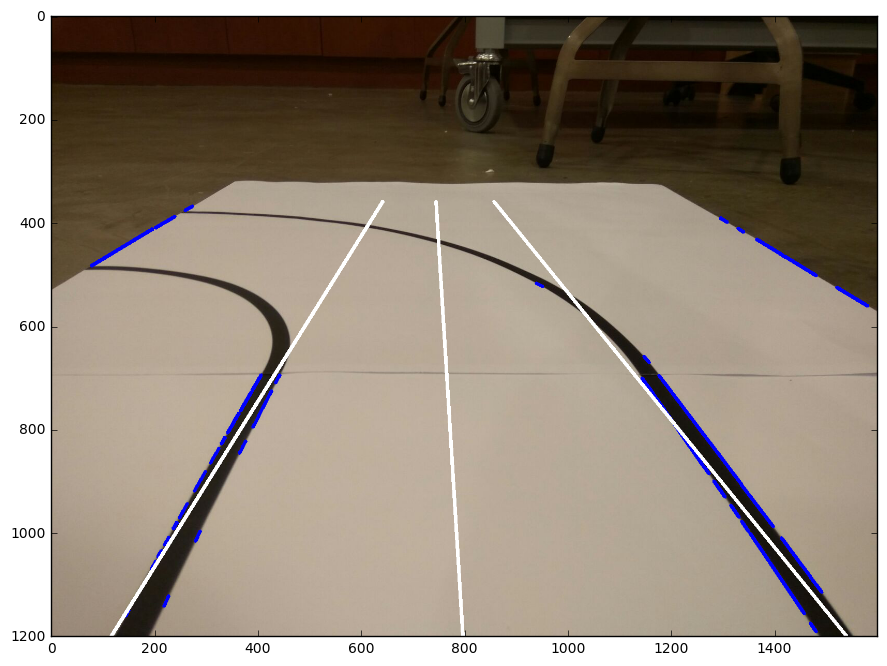

In [23]:
img_bgr = cv2.imread('pics/phone2.jpeg',1)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

lr = LaneTracker(img_rgb, theta_threshold = 0.25, horizon_threshold = 0.3)

offset, angle = lr.get_mid_lane()
lr.plot_img()

In [24]:
print(offset, angle)

(array([[-2.83766426]]), array([[ 16.29054479]]))


In [5]:
def scale_line(x1, y1, x2, y2, road_horizon, frame_height):
    # scale the farthest point of the segment to be on the drawing horizon
    if x1 == x2:
        if y1 < y2:
            y1 = road_horizon
            y2 = frame_height
            return x1, y1, x2, y2
        else:
            y2 = road_horizon
            y1 = frame_height
            return x1, y1, x2, y2
    if y1 < y2:
        m = (y1-y2)/(x1-x2)
        x1 = ((road_horizon-y1)/m) + x1
        y1 = road_horizon
        x2 = ((frame_height-y2)/m) + x2
        y2 = frame_height
    else:
        m = (y2-y1)/(x2-x1)
        x2 = ((road_horizon-y2)/m) + x2
        y2 = road_horizon
        x1 = ((frame_height-y1)/m) + x1
        y1 = frame_height
    return x1, y1, x2, y2